In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [2]:
netfeat = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X

Using cache found in /home/de/.cache/torch/hub/facebookresearch_dinov2_main
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.MNIST('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.MNIST('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


60000

# Parametric TSNE

In [4]:
from ptsne import train_parametric_tsne_model
from ptsne.config import Config

config = Config()
print(f"Training on {config.dev}", flush=True)

Training on cuda


In [5]:
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

In [73]:
from ptsne.ptsne_net import model

In [74]:
from torch.utils.data import TensorDataset

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

100%|██████████| 120/120 [00:07<00:00, 16.62it/s]

====> Epoch: 1. Time 0:00:07.221065. Average loss: 2.5506



100%|██████████| 120/120 [00:07<00:00, 15.88it/s]

====> Epoch: 2. Time 0:00:07.556631. Average loss: 0.9325



100%|██████████| 120/120 [00:06<00:00, 19.10it/s]

====> Epoch: 3. Time 0:00:06.281971. Average loss: 0.5967



100%|██████████| 120/120 [00:06<00:00, 17.55it/s]

====> Epoch: 4. Time 0:00:06.839878. Average loss: 0.4323



100%|██████████| 120/120 [00:07<00:00, 16.15it/s]

====> Epoch: 5. Time 0:00:07.428959. Average loss: 0.3367



100%|██████████| 120/120 [00:04<00:00, 28.92it/s]

====> Epoch: 6. Time 0:00:04.150565. Average loss: 0.2741



100%|██████████| 120/120 [00:05<00:00, 23.03it/s]

====> Epoch: 7. Time 0:00:05.210067. Average loss: 0.2303



100%|██████████| 120/120 [00:07<00:00, 15.71it/s]

====> Epoch: 8. Time 0:00:07.640897. Average loss: 0.1980



100%|██████████| 120/120 [00:07<00:00, 15.95it/s]

====> Epoch: 9. Time 0:00:07.522378. Average loss: 0.1736



100%|██████████| 120/120 [00:07<00:00, 16.25it/s]

====> Epoch: 10. Time 0:00:07.387436. Average loss: 0.1538
Training time: 0:01:07.241894


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


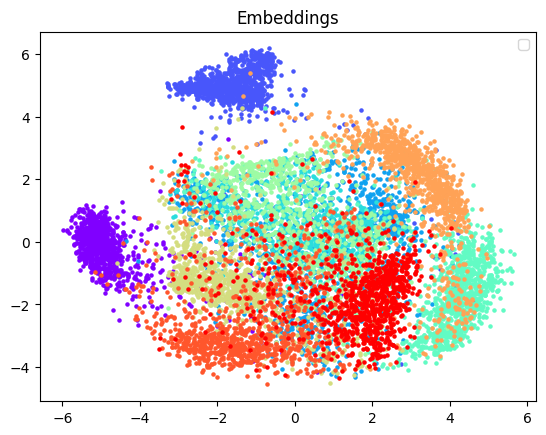

In [75]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

plotsmart(np.array(fs), lbs, "Embeddings", True)

In [76]:
res = {}
ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'] = resmap
resmap

0.5210908827789704

# Parametric UMAP

In [77]:
import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

In [78]:
pumap.fit(torch.stack(trainfs))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fri Dec  6 10:22:04 2024 Building RP forest with 17 trees
Fri Dec  6 10:22:05 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 388 K  | train
----------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.553     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reducing array of shape torch.Size([10000, 1536]) to (10000, 2)


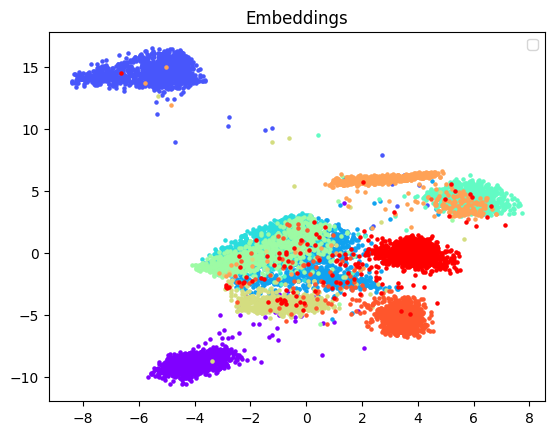

In [79]:
fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))
plotsmart(embedding, lbs, "Embeddings", True)

In [80]:
ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'] = resmap
resmap

0.7471920053395255

In [81]:
res

{'p-tsne': 0.5210908827789704, 'p-umap': 0.7471920053395255}